In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [11]:
class StackedLSTM:
    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        dropout_input=0.0,
        dropout_hidden=0.0,
        init_type="xavier",            # "xavier", "he", "normal", "uniform"
        output_activation="linear",    # "linear", "sigmoid", "tanh", "relu", "softmax"
        normalization="none",          # "layer", "batch", "group", "none"
        num_groups=4,                  # only used for group norm
        optimizer="adam",
        return_sequences=False,
        metrics=None,
        seed=None
    ):
        self.input_dim = int(input_dim)
        self.hidden_dims = list(hidden_dims)
        self.output_dim = int(output_dim)
        self.dropout_input = float(dropout_input)
        self.dropout_hidden = float(dropout_hidden)
        self.init_type = init_type.lower()
        self.output_activation = output_activation.lower()
        self.normalization = normalization.lower()
        self.num_groups = int(max(1, num_groups))
        self.optimizer = optimizer.lower()
        self.return_sequences = return_sequences
        self.metrics = metrics or []
        self.rng = np.random.RandomState(seed)

        # Parameter containers
        self.params = {}
        self.grads = {}
        self.opt_cache = {}
        self.running_stats = {}   # for batch-norm (per gate per layer)

        self.init_weights()
        self._reset_optimizer_cache()

    # ---------------- Weight Initialization ---------------- #
    def init_weights(self):
        self.params.clear()
        self.running_stats.clear()
        prev_dim = self.input_dim
        for li, hdim in enumerate(self.hidden_dims):
            for gate in ("f", "i", "g", "o"):
                W_key = f"W_{gate}_{li}"
                b_key = f"b_{gate}_{li}"
                self.params[W_key] = self._init_matrix(prev_dim + hdim, hdim)
                # Forget gate bias to +1 helps early training
                if gate == "f":
                    self.params[b_key] = np.ones((1, hdim))
                else:
                    self.params[b_key] = np.zeros((1, hdim))
                # norm params (gamma/beta) per gate
                self.params[f"gamma_{gate}_{li}"] = np.ones((1, hdim))
                self.params[f"beta_{gate}_{li}"]  = np.zeros((1, hdim))
                # batch-norm running stats
                self.running_stats[f"mu_{gate}_{li}"] = np.zeros((1, hdim))
                self.running_stats[f"var_{gate}_{li}"] = np.ones((1, hdim))
            prev_dim = hdim
        # Output layer
        self.params["Wy"] = self._init_matrix(prev_dim, self.output_dim)
        self.params["by"] = np.zeros((1, self.output_dim))

    def _init_matrix(self, fan_in, fan_out):
        if self.init_type == "xavier":
            scale = np.sqrt(1.0 / fan_in)
            return self.rng.randn(fan_in, fan_out) * scale
        elif self.init_type == "he":
            scale = np.sqrt(2.0 / fan_in)
            return self.rng.randn(fan_in, fan_out) * scale
        elif self.init_type == "uniform":
            limit = np.sqrt(3.0 / fan_in)
            return self.rng.uniform(-limit, limit, size=(fan_in, fan_out))
        # default "normal"
        return self.rng.randn(fan_in, fan_out) * 0.01

    # ---------------- Activations ---------------- #
    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -50, 50)))

    def _apply_output_activation(self, y):
        if self.output_activation == "linear":
            return y
        if self.output_activation == "sigmoid":
            return self._sigmoid(y)
        if self.output_activation == "tanh":
            return np.tanh(y)
        if self.output_activation == "relu":
            return np.maximum(0, y)
        if self.output_activation == "softmax":
            exps = np.exp(y - y.max(axis=1, keepdims=True))
            return exps / exps.sum(axis=1, keepdims=True)
        raise ValueError("Unknown output_activation")

    # ---------------- Dropout masks ---------------- #
    def _variational_masks(self, N, T=None):
        """Variational dropout: one mask per sequence, reused across time."""
        x_mask = np.ones((N, self.input_dim))
        if self.dropout_input > 0:
            x_mask = (self.rng.rand(N, self.input_dim) > self.dropout_input) / (1 - self.dropout_input)
        h_masks = []
        for h in self.hidden_dims:
            if self.dropout_hidden > 0:
                h_masks.append((self.rng.rand(N, h) > self.dropout_hidden) / (1 - self.dropout_hidden))
            else:
                h_masks.append(np.ones((N, h)))
        return x_mask, h_masks

    # ---------------- Normalization helpers ---------------- #
    def _norm_forward(self, z, gamma, beta, gate_key, training=True, momentum=0.9, eps=1e-5):
        """Applies chosen normalization to pre-activation z (N, H). Returns (z_norm, cache)."""
        mode = self.normalization
        if mode == "none":
            return z, (mode, None)

        if mode == "layer":
            mu = z.mean(axis=1, keepdims=True)
            var = z.var(axis=1, keepdims=True)
            z_hat = (z - mu) / np.sqrt(var + eps)
            out = gamma * z_hat + beta
            cache = (z, z_hat, mu, var, gamma, beta, eps)
            return out, (mode, cache)

        if mode == "batch":
            # per-feature across batch
            if training:
                mu = z.mean(axis=0, keepdims=True)
                var = z.var(axis=0, keepdims=True)
                # update running stats
                self.running_stats[f"mu_{gate_key}"] = momentum * self.running_stats[f"mu_{gate_key}"] + (1 - momentum) * mu
                self.running_stats[f"var_{gate_key}"] = momentum * self.running_stats[f"var_{gate_key}"] + (1 - momentum) * var
            else:
                mu = self.running_stats[f"mu_{gate_key}"]
                var = self.running_stats[f"var_{gate_key}"]
            z_hat = (z - mu) / np.sqrt(var + eps)
            out = gamma * z_hat + beta
            cache = (z, z_hat, mu, var, gamma, beta, eps)
            return out, (mode, cache)

        if mode == "group":
            G = self.num_groups
            N, H = z.shape
            assert H % G == 0, "Hidden dim must be divisible by num_groups for group norm"
            z_ = z.reshape(N, G, H // G)
            mu = z_.mean(axis=2, keepdims=True)
            var = z_.var(axis=2, keepdims=True)
            z_hat_ = (z_ - mu) / np.sqrt(var + eps)
            z_hat = z_hat_.reshape(N, H)
            out = gamma * z_hat + beta
            cache = (z, z_hat_, mu, var, gamma, beta, eps, G)
            return out, (mode, cache)

        raise ValueError("Unknown normalization mode")

    def _norm_backward(self, dout, cache):
        """Given upstream grad dout (N, H) and cache from _norm_forward, return dZ, dGamma, dBeta."""
        mode, c = cache
        if mode == "none" or c is None:
            return dout, 0.0, 0.0

        if mode in ("layer", "batch"):
            z, z_hat, mu, var, gamma, beta, eps = c
            N, H = z.shape
            dbeta = dout.sum(axis=0, keepdims=True)
            dgamma = (dout * z_hat).sum(axis=0, keepdims=True)
            dz_hat = dout * gamma
            if mode == "layer":
                muH = H
                dvar = (-0.5) * ((var + eps) ** -1.5) * (dz_hat * (z - mu)).sum(axis=1, keepdims=True)
                dmu = -(dz_hat / np.sqrt(var + eps)).sum(axis=1, keepdims=True) - 2 * dvar * (z - mu).mean(axis=1, keepdims=True)
                dz = dz_hat / np.sqrt(var + eps) + (2.0 / muH) * dvar * (z - mu) + dmu / muH
            else:  # batch norm
                muN = N
                dvar = (-0.5) * ((var + eps) ** -1.5) * (dz_hat * (z - mu)).sum(axis=0, keepdims=True)
                dmu = -(dz_hat / np.sqrt(var + eps)).sum(axis=0, keepdims=True) - 2 * dvar * (z - mu).mean(axis=0, keepdims=True)
                dz = dz_hat / np.sqrt(var + eps) + (2.0 / muN) * dvar * (z - mu) + dmu / muN
            return dz, dgamma, dbeta

        if mode == "group":
            z, z_hat_, mu, var, gamma, beta, eps, G = c
            N, _, groupH = z_hat_.shape
            H = G * groupH
            z_ = z.reshape(N, G, groupH)
            dbeta = dout.sum(axis=0, keepdims=True)
            z_hat = z_hat_.reshape(N, H)
            dgamma = (dout * z_hat).sum(axis=0, keepdims=True)
            dz_hat = (dout * gamma).reshape(N, G, groupH)
            dvar = (-0.5) * ((var + eps) ** -1.5) * (dz_hat * (z_ - mu)).sum(axis=2, keepdims=True)
            dmu = -(dz_hat / np.sqrt(var + eps)).sum(axis=2, keepdims=True) - 2 * dvar * (z_ - mu).mean(axis=2, keepdims=True)
            dz_ = dz_hat / np.sqrt(var + eps) + (2.0 / groupH) * dvar * (z_ - mu) + dmu / groupH
            dz = dz_.reshape(N, H)
            return dz, dgamma, dbeta

        raise ValueError("Unknown normalization mode in backward")

    # ---------------- Forward Pass ---------------- #
    def forward(self, X, training=True):
        N, T, D = X.shape
        Hs = [np.zeros((N, h)) for h in self.hidden_dims]
        Cs = [np.zeros((N, h)) for h in self.hidden_dims]

        # Variational dropout masks (per sequence, reused across time)
        x_mask, h_masks = self._variational_masks(N, T)

        outputs = []
        caches = []

        for t in range(T):
            x_t = X[:, t, :] * x_mask  # only first layer uses x_mask
            layer_cache = []
            for li, hdim in enumerate(self.hidden_dims):
                # concat input and previous hidden (apply hidden dropout mask to h_prev)
                h_prev_masked = Hs[li] * h_masks[li]
                concat = np.concatenate([x_t, h_prev_masked], axis=1)

                # pre-activations
                zf = concat @ self.params[f"W_f_{li}"] + self.params[f"b_f_{li}"]
                zi = concat @ self.params[f"W_i_{li}"] + self.params[f"b_i_{li}"]
                zg = concat @ self.params[f"W_g_{li}"] + self.params[f"b_g_{li}"]
                zo = concat @ self.params[f"W_o_{li}"] + self.params[f"b_o_{li}"]

                # normalization per gate
                f_norm, f_cache = self._norm_forward(zf, self.params[f"gamma_f_{li}"], self.params[f"beta_f_{li}"], gate_key=f"f_{li}", training=training)
                i_norm, i_cache = self._norm_forward(zi, self.params[f"gamma_i_{li}"], self.params[f"beta_i_{li}"], gate_key=f"i_{li}", training=training)
                g_norm, g_cache = self._norm_forward(zg, self.params[f"gamma_g_{li}"], self.params[f"beta_g_{li}"], gate_key=f"g_{li}", training=training)
                o_norm, o_cache = self._norm_forward(zo, self.params[f"gamma_o_{li}"], self.params[f"beta_o_{li}"], gate_key=f"o_{li}", training=training)

                # gates
                f = self._sigmoid(f_norm)
                i = self._sigmoid(i_norm)
                g = np.tanh(g_norm)
                o = self._sigmoid(o_norm)

                # states
                C_new = f * Cs[li] + i * g
                H_new = o * np.tanh(C_new)

                # store
                cache_l = {
                    "concat": concat, "h_prev": Hs[li], "c_prev": Cs[li],
                    "f": f, "i": i, "g": g, "o": o,
                    "c": C_new, "h": H_new,
                    "norm_caches": {"f": f_cache, "i": i_cache, "g": g_cache, "o": o_cache},
                    "h_mask": h_masks[li],
                    # only layer 0 has input dropout; deeper layers' "x" is previous layer's h
                    "x_mask": x_mask if li == 0 else None
                }
                layer_cache.append(cache_l)

                # advance
                Cs[li] = C_new
                Hs[li] = H_new
                x_t = H_new  # feed to next layer

            # output at this time step
            y_t = Hs[-1] @ self.params["Wy"] + self.params["by"]
            y_act = self._apply_output_activation(y_t)
            outputs.append(y_act)
            caches.append(layer_cache)

        # (N,T,K) if sequences requested, else (N,K)
        if self.return_sequences:
            Y = np.stack(outputs, axis=1)  # (N, T, K)
        else:
            Y = outputs[-1]               # (N, K)

        return Y, {"caches": caches, "Hs": Hs, "Cs": Cs, "training": training}

    # ---------------- Backpropagation Through Time ---------------- #
    def __backprop(self, X, Y_true, Y_pred, cache, loss_type=None, clip=1.0):
        # Make shapes consistent: always (N, T, K)
        if Y_pred.ndim == 2:  # (N, K)
            N, K = Y_pred.shape
            T = 1
            Yp = Y_pred.reshape(N, 1, K)
            Yt = Y_true.reshape(N, 1, K)
        else:
            N, T, K = Y_pred.shape
            Yp = Y_pred
            Yt = Y_true

        if loss_type is None:
            loss_type = "ce" if self.output_activation == "softmax" else "mse"

        # dL/dY
        if loss_type in ("ce", "crossentropy"):
            dY = (Yp - Yt) / (N * T)
        else:  # MSE
            dY = 2 * (Yp - Yt) / (N * T)

        # zero grads
        for k in self.params:
            self.grads[k] = np.zeros_like(self.params[k])

        caches = cache["caches"]
        dH_next = [np.zeros((N, h)) for h in self.hidden_dims]
        dC_next = [np.zeros((N, h)) for h in self.hidden_dims]

        for t in reversed(range(T)):
            # output layer (only top layer feeds Wy)
            h_top = caches[t][-1]["h"]  # (N, H_last)
            dy = dY[:, t, :] if T > 1 else dY[:, 0, :]
            self.grads["Wy"] += h_top.T @ dy
            self.grads["by"] += dy.sum(axis=0, keepdims=True)
            dh = dy @ self.params["Wy"].T  # upstream into top hidden

            # stacked layers (top -> bottom)
            for li in reversed(range(len(self.hidden_dims))):
                c = caches[t][li]

                # combine upstream and time carry, then apply variational dropout mask ON h_t
                dh_total = dh + dH_next[li]
                if c.get("h_mask") is not None:
                    dh_total *= c["h_mask"]

                # through h_t = o * tanh(c_t)
                tanh_c = np.tanh(c["c"])
                do = dh_total * tanh_c
                dc = dh_total * c["o"] * (1 - tanh_c**2) + dC_next[li]

                # into gates (post-activation grads)
                df = dc * c["c_prev"]
                di = dc * c["g"]
                dg = dc * c["i"]
                dc_prev = dc * c["f"]

                # to pre-activations (sigmoid/tanh derivatives)
                df *= c["f"] * (1 - c["f"])
                di *= c["i"] * (1 - c["i"])
                dg *= (1 - c["g"] ** 2)
                do *= c["o"] * (1 - c["o"])

                # norm backward (if any). Each returns d pre-norm + dgamma, dbeta
                dzf, dgfam, dbfam = self._norm_backward(df, c["norm_caches"]["f"])
                dzi, dgiam, dbiam = self._norm_backward(di, c["norm_caches"]["i"])
                dzg, dggam, dbgma = self._norm_backward(dg, c["norm_caches"]["g"])
                dzo, dgoam, dboam = self._norm_backward(do, c["norm_caches"]["o"])

                # accumulate gamma/beta grads
                self.grads[f"gamma_f_{li}"] += dgfam; self.grads[f"beta_f_{li}"]  += dbfam
                self.grads[f"gamma_i_{li}"] += dgiam; self.grads[f"beta_i_{li}"]  += dbiam
                self.grads[f"gamma_g_{li}"] += dggam; self.grads[f"beta_g_{li}"]  += dbgma
                self.grads[f"gamma_o_{li}"] += dgoam; self.grads[f"beta_o_{li}"]  += dboam

                # params
                concat = c["concat"]  # (N, D_in + H_li)
                self.grads[f"W_f_{li}"] += concat.T @ dzf
                self.grads[f"b_f_{li}"] += dzf.sum(axis=0, keepdims=True)
                self.grads[f"W_i_{li}"] += concat.T @ dzi
                self.grads[f"b_i_{li}"] += dzi.sum(axis=0, keepdims=True)
                self.grads[f"W_g_{li}"] += concat.T @ dzg
                self.grads[f"b_g_{li}"] += dzg.sum(axis=0, keepdims=True)
                self.grads[f"W_o_{li}"] += concat.T @ dzo
                self.grads[f"b_o_{li}"] += dzo.sum(axis=0, keepdims=True)

                # split concat grads -> x and h_prev
                dconcat = (dzf @ self.params[f"W_f_{li}"].T +
                           dzi @ self.params[f"W_i_{li}"].T +
                           dzg @ self.params[f"W_g_{li}"].T +
                           dzo @ self.params[f"W_o_{li}"].T)

                H_li = c["h"].shape[1]
                D_in = dconcat.shape[1] - H_li
                dx = dconcat[:, :D_in]
                dh_prev = dconcat[:, D_in:]

                # input variational dropout backward only for layer 0
                if li == 0 and c.get("x_mask") is not None:
                    dx *= c["x_mask"]

                # carry to previous time
                dH_next[li] = dh_prev
                dC_next[li] = dc_prev

                # upstream into lower layer at same time step
                dh = dx

        # clip
        for k in self.grads:
            self.grads[k] = np.clip(self.grads[k], -clip, clip)

    # ---------------- Optimizers ---------------- #
    def update_params(self, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        opt = self.optimizer
        for k, g in self.grads.items():
            if k not in self.params:
                continue
            if opt == "sgd":
                self.params[k] -= lr * g
            elif opt == "rmsprop":
                v = self.opt_cache.get(k)
                if v is None:
                    v = np.zeros_like(g)
                v = 0.9 * v + 0.1 * (g * g)
                self.params[k] -= lr * g / (np.sqrt(v) + eps)
                self.opt_cache[k] = v
            else:  # adam (default)
                m, v, t = self.opt_cache.get(k, (np.zeros_like(g), np.zeros_like(g), 0))
                t += 1
                m = beta1 * m + (1 - beta1) * g
                v = beta2 * v + (1 - beta2) * (g * g)
                mhat = m / (1 - beta1 ** t)
                vhat = v / (1 - beta2 ** t)
                self.params[k] -= lr * mhat / (np.sqrt(vhat) + eps)
                self.opt_cache[k] = (m, v, t)

    def _reset_optimizer_cache(self):
        self.opt_cache = {}

    # ---------------- Loss ---------------- #
    def loss_fn(self, Y_pred, Y_true, loss_type="auto"):
        # If labels are (batch,) but predictions are (batch,1), fix shape
        if Y_true.ndim == 1 and Y_pred.ndim == 2 and Y_pred.shape[1] == 1:
            Y_true = Y_true.reshape(-1, 1)
    
        if loss_type == "auto":
            if self.output_activation == "softmax":
                loss_type = "crossentropy"
            elif self.output_activation in ("sigmoid", "logistic"):
                # Binary outputs (e.g. parity test)
                loss_type = "bce"
            else:
                # Default to regression loss
                loss_type = "mse"
    
        if loss_type in ("crossentropy", "ce"):
            eps = 1e-12
            Y_pred = np.clip(Y_pred, eps, 1 - eps)
            return -np.mean(np.sum(Y_true * np.log(Y_pred), axis=-1))
        elif loss_type in ("bce", "binary_crossentropy"):
            eps = 1e-12
            Y_pred = np.clip(Y_pred, eps, 1 - eps)
            return -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
        elif loss_type == "mse":
            return np.mean((Y_pred - Y_true) ** 2)
        else:
            raise ValueError(f"Unknown loss_type: {loss_type}")

    # ---------------- Metrics ---------------- #
    def compute_metrics(self, Y_pred, Y_true):
        results = {}
        # shape fixes for common binary case
        if Y_true.ndim == 1 and Y_pred.ndim == 2 and Y_pred.shape[1] == 1:
            Y_true = Y_true.reshape(-1, 1)

        for m in self.metrics:
            if m == "accuracy":
                if self.output_activation == "softmax":
                    results["accuracy"] = np.mean(
                        np.argmax(Y_pred, axis=1) == np.argmax(Y_true, axis=1)
                    )
                else:  # sigmoid/binary
                    results["accuracy"] = np.mean((Y_pred > 0.5).astype(int) == Y_true)
            elif m == "mse":
                results["mse"] = np.mean((Y_pred - Y_true) ** 2)
            elif m == "mae":
                results["mae"] = np.mean(np.abs(Y_pred - Y_true))
        return results

    # ---------------- Training Loop ---------------- #
    def fit(self, X, Y, epochs=10, batch_size=32, lr=0.01, optimizer="adam",
            loss_type="auto", clip=5.0, verbose_every=1, shuffle=True,
            validation_split=0.0, X_val=None, Y_val=None,
            early_stopping=True, patience=10, restore_best=True,
            lr_schedule=True, lr_factor=0.5, min_lr=1e-6,
            plot=True):
    
        # split validation set if requested
        if X_val is None and validation_split > 0:
            split_idx = int((1 - validation_split) * len(X))
            X, X_val = X[:split_idx], X[split_idx:]
            Y, Y_val = Y[:split_idx], Y[split_idx:]
    
        if optimizer is not None:
            self.optimizer = optimizer.lower()
    
        history = {"loss": []}
        for m in self.metrics:
            history[m] = []
        if X_val is not None:
            history["val_loss"] = []
            for m in self.metrics:
                history[f"val_{m}"] = []
    
        best_val_loss = float("inf")
        best_params = None
        patience_counter = 0
    
        N = X.shape[0]
        for e in range(epochs):
            if shuffle:
                idx = self.rng.permutation(N)
                X = X[idx]
                Y = Y[idx]
    
            batch_losses = []
            metrics_out = {}
            for i in range(0, N, batch_size):
                xb = X[i:i + batch_size]
                yb = Y[i:i + batch_size]
                Y_pred, cache = self.forward(xb, training=True)
                loss = self.loss_fn(Y_pred, yb, loss_type)
                batch_losses.append(loss)
                self.__backprop(xb, yb, Y_pred, cache, loss_type=loss_type, clip=clip)
                self.update_params(lr=lr)
    
            epoch_loss = float(np.mean(batch_losses)) if batch_losses else 0.0
            history["loss"].append(epoch_loss)
    
            if (e + 1) % verbose_every == 0:
                metrics_out = self.compute_metrics(Y_pred, yb)
                msg = f"Epoch {e+1}/{epochs} - Loss: {epoch_loss:.4f}"
                for k, v in metrics_out.items():
                    msg += f", {k}: {v:.4f}"
    
                if X_val is not None and Y_val is not None:
                    Y_val_pred, _ = self.forward(X_val, training=False)
                    val_loss = self.loss_fn(Y_val_pred, Y_val, loss_type)
                    val_metrics = self.compute_metrics(Y_val_pred, Y_val)
                    msg += f" | Val Loss: {val_loss:.4f}"
                    for k, v in val_metrics.items():
                        msg += f", Val {k}: {v:.4f}"
                    history["val_loss"].append(val_loss)
                    for k, v in val_metrics.items():
                        history[f"val_{k}"].append(v)
    
                    # ----- Early stopping -----
                    if early_stopping:
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            patience_counter = 0
                            if restore_best:
                                best_params = copy.deepcopy(self.params)
                        else:
                            patience_counter += 1
                            if patience_counter >= patience:
                                print(f"Early stopping at epoch {e+1}")
                                if restore_best and best_params is not None:
                                    self.params = copy.deepcopy(self.params)
                                if plot:
                                    self._plot_history(history)
                                return history
    
                    # ----- LR scheduling -----
                    if lr_schedule and patience_counter > 0 and patience_counter % (patience // 2) == 0:
                        new_lr = max(lr * lr_factor, min_lr)
                        if new_lr < lr:
                            print(f"Reducing LR: {lr:.6f} -> {new_lr:.6f}")
                            lr = new_lr
    
                print(msg)
    
            for k, v in metrics_out.items():
                history[k].append(v)
    
        if restore_best and best_params is not None:
            self.params = copy.deepcopy(best_params)
    
        if plot:
            self._plot_history(history)
    
        return history
    
    
    def _plot_history(self, history):
        """Helper to plot training curves"""
        plt.figure(figsize=(10, 5))
    
        # --- Loss ---
        plt.subplot(1, 2, 1)
        plt.plot(history["loss"], label="train")
        if "val_loss" in history:
            plt.plot(history["val_loss"], label="val")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
    
        # --- Metrics (first one only for simplicity) ---
        metric_keys = [m for m in history.keys() if m not in ("loss", "val_loss")]
        if metric_keys:
            plt.subplot(1, 2, 2)
            key = metric_keys[0]  # show first metric
            plt.plot(history[key], label=f"train {key}")
            val_key = f"val_{key}"
            if val_key in history:
                plt.plot(history[val_key], label=val_key)
            plt.title(key)
            plt.xlabel("Epoch")
            plt.ylabel(key)
            plt.legend()
    
        plt.tight_layout()
        plt.show()

    # ---------------- Prediction ---------------- #
    def predict(self, X):
        Y_pred, _ = self.forward(X, training=False)
        # Forward already returned (N,K) if return_sequences=False
        return Y_pred


In [3]:
# Generate dataset
def gen_parity_data(num_samples=1000, seq_len=8):
    X = np.random.randint(0, 2, size=(num_samples, seq_len, 1))
    y = np.sum(X, axis=1) % 2
    y = y.reshape(-1, 1)  # (batch, output_dim)
    return X, y

In [4]:
def gen_sine_data(num_samples=2000, seq_len=20):
    X = np.zeros((num_samples, seq_len, 1))
    y = np.zeros((num_samples, 1))
    for i in range(num_samples):
        freq = np.random.uniform(0.1, 0.5)      # random frequency
        phase = np.random.uniform(0, 2*np.pi)   # random phase
        t = np.linspace(0, 2*np.pi, seq_len+1)  # seq_len inputs + 1 target
        wave = np.sin(freq * t + phase)
        X[i, :, 0] = wave[:-1]  # input sequence
        y[i, 0] = wave[-1]      # predict the next value
    return X, y

In [5]:
def gen_cosine_data(num_samples=2000, seq_len=20):
    X = np.linspace(0, 4*np.pi, seq_len+1)  # seq + 1 for prediction target
    data = np.cos(X)
    sequences = []
    targets = []
    for i in range(num_samples):
        shift = np.random.randint(0, 50)  # random phase shift
        seq = np.cos(X + shift * 0.1)
        sequences.append(seq[:-1].reshape(-1, 1))  # input sequence
        targets.append(seq[-1])  # predict next value
    return np.array(sequences), np.array(targets).reshape(-1, 1)

Epoch 1/20 - Loss: 0.9554, mse: 1.0343 | Val Loss: 1.1768, Val mse: 1.1768
Epoch 2/20 - Loss: 1.3276, mse: 1.1549 | Val Loss: 1.4995, Val mse: 1.4995
Epoch 3/20 - Loss: 1.6534, mse: 2.1018 | Val Loss: 1.8138, Val mse: 1.8138
Epoch 4/20 - Loss: 1.9285, mse: 1.7094 | Val Loss: 2.0909, Val mse: 2.0909
Epoch 5/20 - Loss: 2.1788, mse: 2.3034 | Val Loss: 2.2802, Val mse: 2.2802
Epoch 6/20 - Loss: 2.3470, mse: 2.4808 | Val Loss: 2.4172, Val mse: 2.4172
Epoch 7/20 - Loss: 2.4442, mse: 2.5876 | Val Loss: 2.4929, Val mse: 2.4929
Epoch 8/20 - Loss: 2.5157, mse: 2.8721 | Val Loss: 2.5450, Val mse: 2.5450
Epoch 9/20 - Loss: 2.5637, mse: 2.8777 | Val Loss: 2.5793, Val mse: 2.5793
Epoch 10/20 - Loss: 2.5911, mse: 2.7803 | Val Loss: 2.6021, Val mse: 2.6021
Epoch 11/20 - Loss: 2.6133, mse: 2.4997 | Val Loss: 2.6205, Val mse: 2.6205
Epoch 12/20 - Loss: 2.6311, mse: 2.5954 | Val Loss: 2.6335, Val mse: 2.6335
Epoch 13/20 - Loss: 2.6414, mse: 2.6434 | Val Loss: 2.6419, Val mse: 2.6419
Epoch 14/20 - Loss: 2

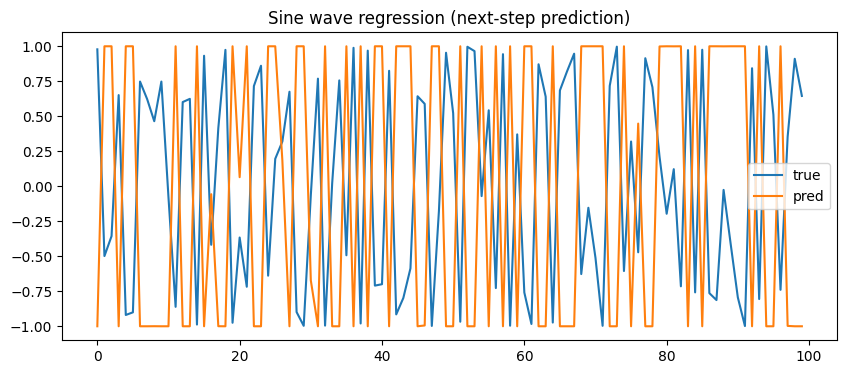

In [25]:
X_train, y_train = gen_sine_data(2000, seq_len=20)
X_test, y_test   = gen_sine_data(500, seq_len=20)

# ---- Model ----
model = StackedLSTM(
    input_dim=1,
    hidden_dims=[32],
    output_dim=1,
    output_activation="tanh",   # no sigmoid/softmax, just raw regression
    optimizer="adam",
    normalization="none",
    return_sequences=False,
    metrics=["mse"]
)

# ---- Train ----
history = model.fit(
    X_train, y_train,
    epochs=20, batch_size=32, lr=1e-3,
    validation_split=0.2,
    verbose_every=1
)

# ---- Evaluate ----
y_pred = model.predict(X_test)
acc = np.mean((y_pred > 0.5).astype(int) == y_test)
print("Test accuracy:", acc)
# Plot predictions vs ground truth for first 100 samples
plt.figure(figsize=(10,4))
plt.plot(y_test[:100], label="true")
plt.plot(y_pred[:100], label="pred")
plt.legend()
plt.title("Sine wave regression (next-step prediction)")
plt.show()

Epoch 5/100 - Loss: 0.5325, mse: 0.5338 | Val Loss: 0.5334, Val mse: 0.5334
Epoch 10/100 - Loss: 0.4913, mse: 0.5383 | Val Loss: 0.5122, Val mse: 0.5122
Epoch 15/100 - Loss: 0.4880, mse: 0.5238 | Val Loss: 0.4964, Val mse: 0.4964
Epoch 20/100 - Loss: 0.4544, mse: 0.4019 | Val Loss: 0.4884, Val mse: 0.4884
Epoch 25/100 - Loss: 0.4458, mse: 0.4568 | Val Loss: 0.4578, Val mse: 0.4578
Epoch 30/100 - Loss: 0.4345, mse: 0.4884 | Val Loss: 0.4506, Val mse: 0.4506
Epoch 35/100 - Loss: 0.4115, mse: 0.4181 | Val Loss: 0.4384, Val mse: 0.4384
Epoch 40/100 - Loss: 0.4127, mse: 0.3271 | Val Loss: 0.4487, Val mse: 0.4487
Epoch 45/100 - Loss: 0.4064, mse: 0.4786 | Val Loss: 0.4324, Val mse: 0.4324
Epoch 50/100 - Loss: 0.3993, mse: 0.4821 | Val Loss: 0.4122, Val mse: 0.4122
Epoch 55/100 - Loss: 0.4137, mse: 0.3923 | Val Loss: 0.3875, Val mse: 0.3875
Epoch 60/100 - Loss: 0.3875, mse: 0.4183 | Val Loss: 0.3917, Val mse: 0.3917
Epoch 65/100 - Loss: 0.3948, mse: 0.4508 | Val Loss: 0.4325, Val mse: 0.4325


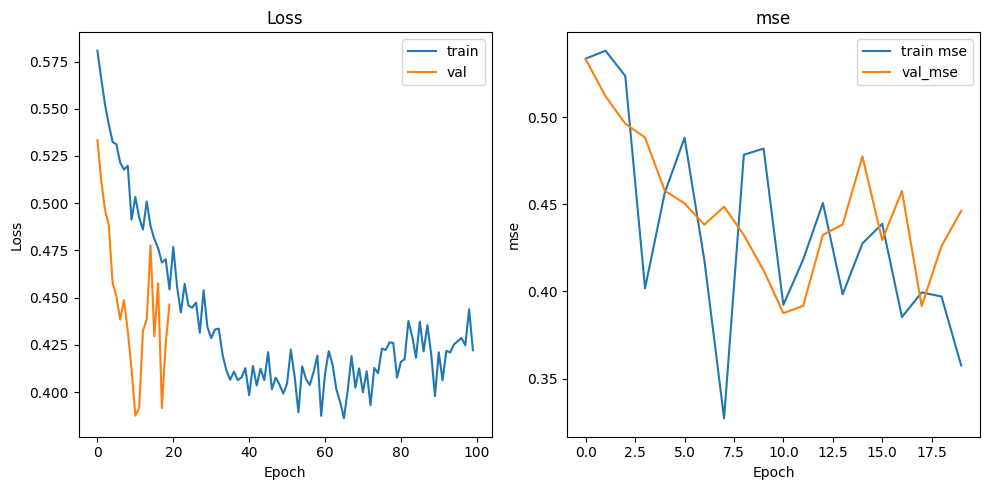

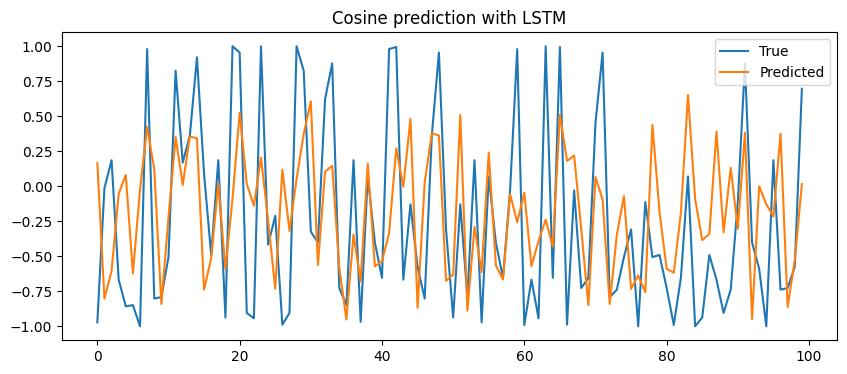

In [12]:
X_train, y_train = gen_cosine_data(2000, seq_len=20)
X_test, y_test   = gen_cosine_data(500, seq_len=20)

# --- Model ---
model = StackedLSTM(
    input_dim=1,
    hidden_dims=[32],
    output_dim=1,
    output_activation="tanh",
    optimizer="adam",
    normalization="layer",   # <- stabilizes cosine learning
    return_sequences=False,
    metrics=["mse"],
    dropout_input=0.2,
    dropout_hidden=0.2
)


# --- Train ---
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32, lr=5e-5,  # smaller LR
    validation_split=0.2,
    verbose_every=5
)

# --- Evaluate ---
y_pred = model.predict(X_test)

# Plot predictions vs true cosine values
plt.figure(figsize=(10,4))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")
plt.legend()
plt.title("Cosine prediction with LSTM")
plt.show()

In [11]:
X_train, y_train = gen_parity_data(2000, seq_len=8)
X_test, y_test   = gen_parity_data(500, seq_len=8)

model = StackedLSTM(
    input_dim=1,
    hidden_dims=[64],
    output_dim=1,
    output_activation="sigmoid",
    optimizer="adam",
    normalization="none",
    return_sequences=False,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    epochs=200, batch_size=32, lr=1e-3,
    validation_split=0.2,
    verbose_every=10
)


Epoch 10/200 - Loss: 0.6915, accuracy: 0.4688 | Val Loss: 0.6950, Val accuracy: 0.5050
Epoch 20/200 - Loss: 0.6916, accuracy: 0.5000 | Val Loss: 0.6937, Val accuracy: 0.5050
Epoch 30/200 - Loss: 0.6917, accuracy: 0.4375 | Val Loss: 0.6933, Val accuracy: 0.5050
Epoch 40/200 - Loss: 0.6921, accuracy: 0.5938 | Val Loss: 0.6939, Val accuracy: 0.5050
Epoch 50/200 - Loss: 0.6927, accuracy: 0.5312 | Val Loss: 0.6935, Val accuracy: 0.5225
Epoch 60/200 - Loss: 0.6932, accuracy: 0.4688 | Val Loss: 0.6948, Val accuracy: 0.5000
Epoch 70/200 - Loss: 0.6936, accuracy: 0.5625 | Val Loss: 0.6945, Val accuracy: 0.5250
Epoch 80/200 - Loss: 0.6938, accuracy: 0.5000 | Val Loss: 0.6945, Val accuracy: 0.5275
Epoch 90/200 - Loss: 0.6942, accuracy: 0.5000 | Val Loss: 0.6943, Val accuracy: 0.5300
Epoch 100/200 - Loss: 0.6943, accuracy: 0.5312 | Val Loss: 0.6944, Val accuracy: 0.5300
Epoch 110/200 - Loss: 0.6945, accuracy: 0.6875 | Val Loss: 0.6941, Val accuracy: 0.5250
Epoch 120/200 - Loss: 0.6943, accuracy: 0

Test accuracy: 0.492


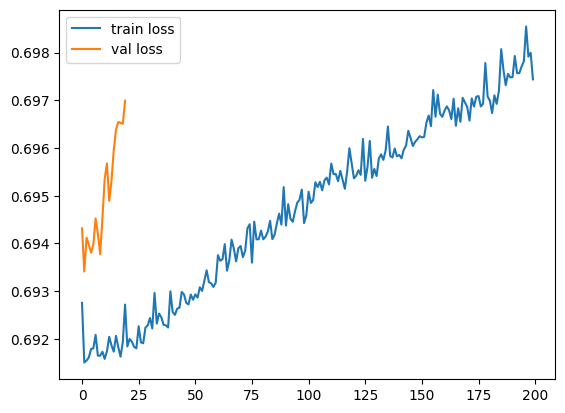

In [10]:
# Evaluate
y_pred = model.predict(X_test)
acc = np.mean((y_pred > 0.5).astype(int) == y_test)
print("Test accuracy:", acc)

plt.plot(history["loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()
plt.show()

# Testing

In [4]:
s1 = np.random.rand(1,15)
s2 = np.random.rand(16,15)
s3 = np.random.rand(16,15)
g = [s1,s2,s3]
print(s1.shape)

(1, 15)


In [5]:
print(s2.sum())

120.83225209476524


In [45]:
s4 = np.random.rand(15,)

In [24]:
dropout = .8
s1 = np.random.rand(1,15)
d1 = np.random.rand(1,15) < dropout
tmp = (s1 * d1) / dropout
print(tmp)

[[0.30570427 0.         0.39445726 0.39480709 1.01234799 0.
  0.         0.88198923 0.11840498 1.0611484  0.78301776 0.00263123
  0.11062156 0.71204032 0.        ]]


In [82]:
g[0][0][0] = 8
g[0][0][1] = 8
g[0][0][2] = 8
g[0][0][3] = 8
g[0][0][3] = 4

In [90]:
threshold = 1
for arr in g:
    #length = arr.shape[0] if i > 3 else arr.shape[0]*arr.shape[1]
    norm = sum([sum(j) for j in arr]) / length
    for i in range(len(arr)):
        norm = sum(arr[i]) / len(arr[i])
        print(norm)
        if abs(norm) >= threshold:
            print("over")
            arr[i] = threshold * (arr[i]/norm)
        #for x in range(len(param)):
        #    
         #   if abs(param[x]) >= threshold:
         #       print("above")
         #       param[x] *= threshold/norm
        #print(param)
        #if abs(param) >= threshold:
        #    param *= threshold/norm

2.2676806174140096
over
0.3517034099110771
0.5180820572745629
0.3187774204864299
0.4522705702943409
0.6702747820749538
0.37210457604177266
0.5861712546214365
0.426866970645028
0.4253853692531773
0.4937130781629099
0.4826773700556101
0.5007882206911465
0.4782924550376553
0.45967609771301654
0.581776761670733
0.5214100685080391
0.5113350754750797
0.5160979147213022
0.5283758399158961
0.35150722534634554
0.6140443200169831
0.6123962765678835
0.37577567896903413
0.5266799237203588
0.571775542098014
0.42757604360583906
0.45316970999235917
0.5059129687681286
0.5375957418634104
0.5827597052127849
0.4990955275097394
0.41238722594434096
0.43499054711471996
0.37336225365820463
0.5467306050022628
0.3928516419877352
0.4458513026620358
0.4426740305544509
0.5227310521710655
0.5023733533141913
0.4927229489893612
0.4126180009988355
0.48955309599878966
0.3553903402019948
0.4739443608088888
0.4699930191648164
0.46196718654835656


In [3]:
series = np.sin(0.1*np.arange(200))

In [3]:
series = np.sin(0.1*np.arange(200)) + 0.1*np.random.randn(200)

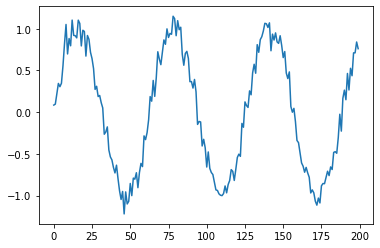

In [4]:
plt.plot(series)

In [5]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [15]:
model = RNN()

In [16]:
model.add_layer(15,'sigmoid','tanh',1)

0 58.714755668912616
500 15.068707173149306
1000 11.475044296415637
1500 10.202627781915947


KeyboardInterrupt: 

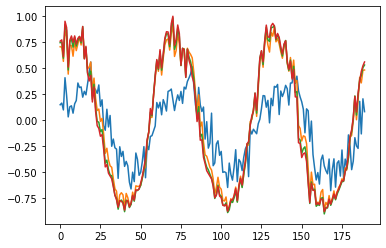

In [17]:
# (X, Y, loss type, # iterations, batch size, learning rate, regulization)
# Loss type('ce': cross-entropy, 'sce': sparse cross-entropy)
lossType = 'mse'
seq_len = 10
epochs = 20000
batchSize = N
learnR = 10e-4
reg_type='none'
reg_val = .1
reg_a = .5
optimizer = 'none'
model.fit(X,Y,seq_len,5000,batchSize,learnR,reg_type=reg_type,reg_val=reg_val,reg_a=reg_a,lossType=lossType,optimizer=optimizer)

In [65]:
M = model.M
W = model.W

In [66]:
yp = model.Yhat

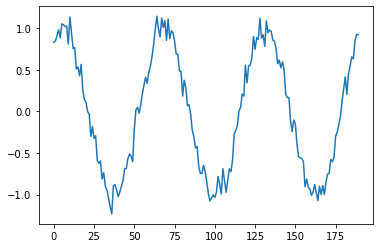

In [67]:
plt.plot(Y)

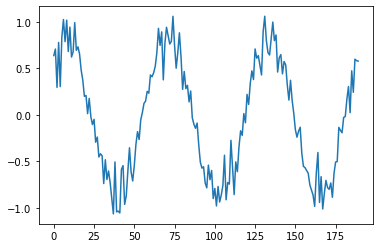

In [68]:
plt.plot(yp)

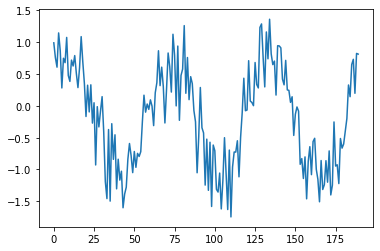

In [37]:
plt.plot(yp)

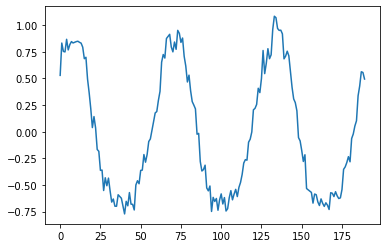

In [46]:
plt.plot(yp)

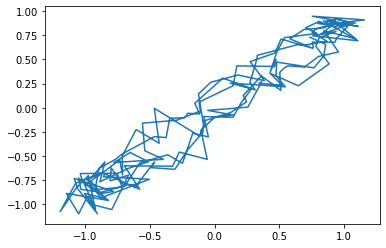

In [121]:
plt.plot(Y,yp)

## Individual methods / testing

In [14]:
def forward(M,W,b,Y):
    N, T, H, D = M[0].shape[0], M[0].shape[1], W[1].shape[1], M[0].shape[2]
    Yp, yp = np.zeros_like(Y), np.zeros_like(Y)
    ht_arr = []
    gt_arr = np.zeros((N,T+1,H,1))
    zt_arr,ht1_arr,ct_arr = np.zeros((N,T+1,H+D,1)),np.zeros((N,T+1,H,1)),np.zeros((N,T+1,H,1))
    it_arr,ft_arr,ot_arr = np.zeros_like(gt_arr),np.zeros_like(gt_arr),np.zeros_like(gt_arr)
    ht_arr.extend([ht1_arr,ct_arr,ft_arr,it_arr,gt_arr,ot_arr,zt_arr])
    z_t = None
    yt = np.zeros((N,T,1))
    X = M[0]

    for i in range(N):
        ht_prev = M[1][i].T
        ct_prev = np.zeros_like(M[1][i]).T
        for t in range(T):
            z_t = np.row_stack((X[i][t],ht_prev.T)).T
            # W_f = W[0], W_i = W[1], W_g = W[2], W_o = W[3], Why = W[4]
            ft = tanh(z_t.dot(W[0]) + b[0])
            it = tanh(z_t.dot(W[1]) + b[1])
            gt = tanh(z_t.dot(W[2]) + b[2])
            ot = tanh(z_t.dot(W[3]) + b[3])
            ct = ft*ct_prev + it*gt
            ht = ot * tanh(ct)
            yp[i] = (ht.dot(W[4]) + b[4])
            ht_arr[0][i][t] = ht.T
            ht_arr[1][i][t] = ct.T
            ht_arr[2][i][t] = ft.T
            ht_arr[3][i][t] = it.T
            ht_arr[4][i][t] = gt.T
            ht_arr[5][i][t] = ot.T
            ht_arr[6][i][t] = z_t.T
            yt[i][t] = yp[i]
            ct_prev = ct
            ht_prev = ht

        Yp[i] = yp[i]
    return Yp,M,ht_arr,yt,z_t

In [18]:
print(z_t.shape)

(1, 16)


In [60]:
def forward0(M,W,b,Y):
    N, T, H = M[0].shape[0], M[0].shape[1], W[1].shape[0]
    Yp, yp = np.zeros_like(Y), np.zeros_like(Y)
    ht_arr = []
    for i in range(1,len(M)-1):
        H = W[i].shape[1]
        ht_arr.append(np.zeros((N,T+1,H,1)))
    yt = np.zeros((N,T,1))
    X = M[0]

    for i in range(N):
        w = 0
        for j in range(len(M)-2):
            
            hh_prev = M[j].reshape(N,-1,1)
            ht_prev = M[j+1][i]
            # Weight counter 
            for t in range(T):
                ht = tanh((hh_prev[i][t].dot(W[w]) + ht_prev.dot(W[w+1]) + b[j]))
                M[j+1][i] = ht
                ht_prev = ht
                ht_arr[j][i][t] = ht.reshape(-1,1)
            w += 2


        yp[i] = (ht.dot(W[-1]) + b[-1])
        yt[i][t] = yp[i].reshape(-1,1)


        Yp[i] = yp[i]
    return Yp,M,ht_arr,yt

In [3]:
def mse(T,Y):
    tot = np.square(T - Y)
    return tot.sum()

In [4]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [5]:
def tanh(Z):
    return np.tanh(Z)

In [6]:
def actf_dv(Z):
    return Z*(1-Z)

In [7]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)

In [8]:
series = np.sin(0.1*np.arange(200))

In [9]:
T = 10
H = 15
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [10]:
# Initialize layers for M
M = []
W = []
b = []
M.append(np.zeros((N,H,D)))
#M.append(np.zeros((N,20)))

# Add input and layer to M
K = 1
M.insert(0,X)
M.append(np.random.randn(N,K))

In [11]:
# Set weights
W = []
b = []
for i in range(len(M)-1):
    if i == (len(M)-2):
        
        W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
        b.append(np.random.randn(K) / np.sqrt(K))
    else:
        for j in range(4):
            # Whf,Whi,Who,Whc
            W.append(np.random.randn(M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1]) / np.sqrt((M[i].shape[2]+M[i+1].shape[1]) + M[i+1].shape[1]))
            b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))

In [15]:
Yp,M,ht,yt,z_t = forward(M,W,b,Y)

In [12]:
M1 = M[1].reshape(-1,15,1)

In [ ]:
M[1][0].dot(W[2]) + b[1] == (M1[0].T.dot(W[2]) + b[1])

In [14]:
zt = np.row_stack((M[0][0][0],M[1][0]))
htprev = M[1][0].T
z_t = np.row_stack((M[0][0][0],htprev.T)).T

In [117]:
#old
h = tanh(M[0][0][0].dot(W[0][0].reshape(1,15)) + M[1][0].reshape(15).dot(W[1][1:]) + b[0])
y0 = h.dot(W[-1]) + b[-1]
#new
h1 = tanh(zt.T.dot(W[0]) + b[0])
y1 = h1.dot(W[-1]) + b[-1]

In [42]:
ct_prev = np.zeros_like(M[1][0]).T
ft = tanh(z_t.dot(W[0]) + b[0])
it = tanh(z_t.dot(W[1]) + b[1])
gt = tanh(z_t.dot(W[2]) + b[2])
ot = tanh(z_t.dot(W[3]) + b[3])
c_t = ft*ct_prev + it*gt
h_t = ot * tanh(c_t)
y = (h_t.dot(W[4]) + b[4])

In [16]:
dr = np.ones_like(ft)

In [29]:
for i in range(dr.shape[1]):
    if random.random() < .2:
        dr[0][i] = 0
dr

array([[0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [43]:
for x in [ft,it,gt,ot]:
    for i in range(x.shape[1]):
        if random.random() < .5:
            x[0][i] = 0

In [44]:
ft

array([[-0.26811279,  0.        ,  0.        , -0.07158144, -0.01684234,
         0.        ,  0.277413  ,  0.        , -0.23312974,  0.57309405,
         0.08259224, -0.24968637,  0.        ,  0.39892337,  0.        ]])

In [170]:
h_t, c_t, f_t, i_t, g_t, o_t, z_t  = ht[0], ht[1], ht[2], ht[3], ht[4], ht[5], ht[6]
W_f, W_i, W_g, W_o, W_y = W[0], W[1], W[2], W[3], W[4]

for i in range(N-1,-1,-1):
    dh_next, dc_next = np.zeros_like(h_t[i][-1]), np.zeros_like(c_t[i][-1])
    for t in range(T-1,-1,-1):
        # Get y
        dv_t = (Y[i] - yt[i][t]).reshape(1,-1)
        dW_v = h_t[i][t].dot(dv_t)
        db_v = dv_t.reshape(-1)
        # hidden state
        dh_t = W_y.dot(dv_t)
        dh_t += dh_next
        # output 
        do_t = dh_t * tanh(c_t[i][t])
        da_o = do_t * actf_dv(o_t[i][t])
        dW_o = z_t[i][t].dot(da_o.T)
        db_o = da_o.reshape(-1)
        # cell state
        dc_t = dh_t * o_t[i][t] * actf_dv(c_t[i][t])
        dc_t += dc_next
        # g(cell) gate
        dg_t = dc_t * i_t[i][t]
        da_g = dg_t * actf_dv(g_t[i][t])
        dW_g = z_t[i][t].dot(da_g.T)
        db_g = da_g.reshape(-1)
        # input gate
        di_t = dc_t * g_t[i][t]
        da_i = di_t * actf_dv(i_t[i][t])
        dW_i = z_t[i][t].dot(da_i.T)
        db_i = da_i.reshape(-1)
        # forget gate
        df_t = dc_t * c_t[i][t-1]
        da_f = df_t * actf_dv(f_t[i][t])
        dW_f = z_t[i][t].dot(da_f.T)
        db_f = da_f.reshape(-1)
        # input
        dz_t = W_f.dot(da_f) + W_i.dot(da_i) + W_o.dot(da_o) + W_g.dot(da_g)

        dh_next = dz_t[1:]
        dc_next = dc_t * f_t[i][t]
    derivArray = []
    derivArray.extend([dW_v,dW_o,dW_g,dW_i,dW_f,db_v,db_o,db_g,db_i,db_f])

In [28]:
h_t, c_t, f_t, i_t, g_t, o_t, z_t  = ht[0], ht[1], ht[2], ht[3], ht[4], ht[5], ht[6]
W_f, W_i, W_g, W_o, W_y = W[0], W[1], W[2], W[3], W[4]
i = N-1
T = h_t.shape[1] - 1
dh_next, dc_next = np.zeros_like(h_t[i][-1]), np.zeros_like(c_t[i][-1])
for t in range(T-1,-1,-1):
    # Get y
    dv_t = (Y[i] - yt[i][t]).reshape(1,-1)
    dW_v = h_t[i][t].dot(dv_t)
    db_v = dv_t.reshape(-1)
    # hidden state
    dh_t = W_y.dot(dv_t)
    dh_t += dh_next
    # output 
    do_t = dh_t * tanh(c_t[i][t])
    da_o = do_t * actf_dv(o_t[i][t])
    dW_o = z_t[i][t].dot(da_o.T)
    db_o = da_o.reshape(-1)
    # cell state
    dc_t = dh_t * o_t[i][t] * actf_dv(c_t[i][t])
    dc_t += dc_next
    # g(cell) gate
    dg_t = dc_t * i_t[i][t]
    da_g = dg_t * actf_dv(g_t[i][t])
    dW_g = z_t[i][t].dot(da_g.T)
    db_g = da_g.reshape(-1)
    # input gate
    di_t = dc_t * g_t[i][t]
    da_i = di_t * actf_dv(i_t[i][t])
    dW_i = z_t[i][t].dot(da_i.T)
    db_i = da_i.reshape(-1)
    # forget gate
    df_t = dc_t * c_t[i][t-1]
    da_f = df_t * actf_dv(f_t[i][t])
    dW_f = z_t[i][t].dot(da_f.T)
    db_f = da_f.reshape(-1)
    # input
    dz_t = W_f.dot(da_f) + W_i.dot(da_i) + W_o.dot(da_o) + W_g.dot(da_g)

    dh_next = dz_t[1:]
    dc_next = dc_t * f_t[i][t]
derivArray = []
derivArray.extend([dW_v,dW_o,dW_g,dW_i,dW_f,db_v,db_o,db_g,db_i,db_f])

In [178]:
h_t[0][0].shape

(15, 1)

In [191]:
d[1].shape

(16, 15)

In [22]:
i -= 1
t -= 1
zt = (Y[i] - yt[i][t]).reshape(1,-1)
dwo = (2/N) * ht[i][t].dot(zt)
db1 = zt.sum()
zt = (W[2].dot(zt) + dnext)*actf_dv(ht[i][t])
W[2] += dwo
b[1] += db1
dxh = (2/N) * M[0][i][t].dot(zt.T)
dhh = (2/N) * ht[i][t-1].dot(zt.T)
db0 = zt.sum()
W[1] += dhh
W[0] += dxh
b[0] += db0
dnext = W[1].dot(zt)

In [31]:
for i in range(N-1,-1,-1):
    for t in range(T-1,-1,-1):
        #print(i, t, yt[i][t])
        zt = (Y[i] - yt[i][t]).reshape(1,-1)
        dwo = (2/N) * ht[i][t].dot(zt)
        db1 = zt.sum()
        zt = (W[2].dot(zt) + dnext)*actf_dv(ht[i][t])
        W[2] += dwo
        b[1] += db1
        dxh = (2/N) * M[0][i][t].dot(zt.T)
        dhh = (2/N) * ht[i][t-1].dot(zt.T)
        db0 = zt.sum()
        W[1] += dhh
        W[0] += dxh
        b[0] += db0
        dnext = W[1].dot(zt)

In [163]:
tempa = np.random.randn(15,1)
tempb = np.random.randn(15,1)
tempc = np.random.randn(1,1)

In [159]:
tempa.T.dot(tempb)

array([[-2.0296615]])

In [160]:
tempb.T.dot(tempa)

array([[-2.0296615]])

In [21]:
w2 = np.vstack([b1,W[2]])
w1 = np.vstack([b0,W[1]])
z2 = np.vstack([np.ones((len(Z[2][0]))),Z[2]])
z1 = np.vstack([np.ones((len(Z[1][0]))),Z[1]])

In [30]:
Y1 = np.vstack([np.ones(1),Y])

In [33]:
dw = np.linalg.solve(np.dot(z2.T, z2), np.dot(z2.T, Y1))

In [15]:
dw1 = np.linalg.solve(np.dot(Yp.T, Yp), np.dot(Yp.T, Y))

In [20]:
W[4].shape

(15, 1)

In [26]:
d1 = np.random.rand(W[4].shape[0],W[4].shape[1]) < 1

In [27]:
d1

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [22]:
p1 = W[4]*d1
p1

array([[-0.21634427],
       [-0.20025169],
       [ 0.04125185],
       [-0.363081  ],
       [ 0.        ],
       [ 0.38600802],
       [-0.26166   ],
       [ 0.56285922],
       [-0.01644235],
       [ 0.11824737],
       [ 0.38012728],
       [-0.34143816],
       [ 0.        ],
       [-0.        ],
       [ 0.        ]])

In [31]:
M[0][0][0].dot(W[0]).shape

ValueError: shapes (1,) and (16,15) not aligned: 1 (dim 0) != 16 (dim 0)

In [35]:
z_t = np.row_stack((M[0][0][0],M[1][0]))

In [38]:
z_t.T.dot(W[0]).shape

(1, 15)

In [45]:
b[0]

array([-0.14183203, -0.07780475, -0.23356375,  0.39923902,  0.51819746,
        0.17472808,  0.1412047 ,  0.11005488,  0.28771586, -0.06291704,
        0.16239791, -0.50121014,  0.30627088,  0.17024809, -0.34089236])

In [18]:
d1 = np.random.rand(W[1].shape[0],W[1].shape[1])
d1 < .7

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True, False,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False,  True,  True,  True],
       [ True,  True,  True, False,  True, False, False, False, False,
        False, False,  True,  True, False,  True],
       [ True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False, False, False,  True],
       [ True,  True, False, False,  True, False, False,  True, False,
         True, False, False,  True,  True, False],
       [ True,  True, False, False,  True, False,  True, False,  True,
        False,  True, False,  True,  True, False],
       [ True,  True, Fa

In [18]:
d = np.zeros((190,10,4,15,1))

In [21]:
d[0][0]

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])